# Clusters

In this notebook, we analyze the data containing information about cell clustering.
To perform this analysis, it is necessary to first execute the script `dat_clusters.py`, which processes the contents of the `dat_labels` folder and generates the following outputs:

- A folder called `dat_clusters`, which contains .dat files with the number of clusters and the size of the largest cluster (for both round and elongated cells) at each time step and for each seed.

- A folder called `cluster_distributions_final`, which contains a .csv file with the sizes of all clusters found in the last step of each seed.

The clustering algorithm used to assign labels to each cell works as follows:
At each time step, we initialize the label of each cell with its unique index. Then, we sort the list of cells and select one. We check which other cells it interacts with. For example, if cell A selected (index 1) interacts with cells B and C (indexes 2 and 3), it assigns them its label (so A, B, and C will now all have label 1). Additionally, any other cell that previously shared the same label as B or C (e.g., a cell D that interacted with B and had label 2) will also have its label updated to 1. In this way, all connected cells end up with the same label, while isolated cells retain unique labels.

We define two types of clustering labels based on different overlap thresholds. In the code, two cells are considered to interact if their overlap exceeds a certain fraction (0.35) of the maximum possible overlap.

- Label 1: Cells belong to the same cluster if their overlap is at least 0.35 times the maximum overlap.

- Label 2: A looser condition is used — cells are considered part of the same cluster if their overlap is at least 0.30 times the maximum.

## Cluster evolution

We are going to start investigating how the number of clusters and the biggest cluster size varies through time given a density.

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

We define some relevant parameters that remains constant during the simulations.

In [2]:
nc = 10_000
cell_area = np.pi
max_step = 60_000
step = 100
delta_t = 0.05

# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

We start creating a function that make a list with the mean of each variable (number of clusters and biggest cluster size) for each step.

In [3]:
def calculate_clusters_vs_time(num_cells, dens, max_step, step, rng_seed):
    """
    Function that calculates both the amount of clusters and the biggest 
    cluster`s size against time for a given density.

    Returns a dataframe with all the data
    """
    # Initialize the lists for label 1
    number_clusters_round = []
    biggest_cluster_size_round = []
    number_clusters_elongated = []
    biggest_cluster_size_elongated = []
    # Initialize the lists for label 2
    number_clusters_round_2 = []
    biggest_cluster_size_round_2 = []
    number_clusters_elongated_2 = []
    biggest_cluster_size_elongated_2 = []
    # Define a boolean to stop where there are no more data
    stop = False
    # Initialize a list with the valid steps
    valid_steps = []
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    for tic in range(100, max_step, step):
        # Initialize arrays to calculate the mean of every seed in this step
        number_clusters_round_step = np.array([])
        biggest_cluster_size_round_step = np.array([])
        number_clusters_elongated_step = np.array([])
        biggest_cluster_size_elongated_step = np.array([])
        # and for label 2
        number_clusters_round_step_2 = np.array([])
        biggest_cluster_size_round_step_2 = np.array([])
        number_clusters_elongated_step_2 = np.array([])
        biggest_cluster_size_elongated_step_2 = np.array([])
        # For each seed we read the file
        for seed in rng_seed:
            dat_actual = (
                    f"{dens_folder}/dat_clusters/clusters_culture_initial_number_of_cells={num_cells}_density={dens}_"
                    f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                    f"rng_seed={seed}_step={tic:05}.dat"
                )
            if os.path.exists(dat_actual):
                df_tic = pd.read_csv(dat_actual)
            else:
                stop = True
                break
            # Take parameters of this particular seed
            number_clusters_round_seed = df_tic["n_round"].mean()
            biggest_cluster_size_round_seed = df_tic["max_round"].mean()
            number_clusters_elongated_seed = df_tic["n_elongated"].mean()
            biggest_cluster_size_elongated_seed = df_tic["max_elongated"].mean()
            # and for label 2
            number_clusters_round_seed_2 = df_tic["n_round_2"].mean()
            biggest_cluster_size_round_seed_2 = df_tic["max_round_2"].mean()
            number_clusters_elongated_seed_2 = df_tic["n_elongated_2"].mean()
            biggest_cluster_size_elongated_seed_2 = df_tic["max_elongated_2"].mean()
            # Add them to the steps's array
            number_clusters_round_step = np.append(number_clusters_round_step, number_clusters_round_seed)
            biggest_cluster_size_round_step = np.append(biggest_cluster_size_round_step, biggest_cluster_size_round_seed)
            number_clusters_elongated_step = np.append(number_clusters_elongated_step, number_clusters_elongated_seed)
            biggest_cluster_size_elongated_step = np.append(biggest_cluster_size_elongated_step, biggest_cluster_size_elongated_seed)
            # and for label 2
            number_clusters_round_step_2 = np.append(number_clusters_round_step_2, number_clusters_round_seed_2)
            biggest_cluster_size_round_step_2 = np.append(biggest_cluster_size_round_step_2, biggest_cluster_size_round_seed_2)
            number_clusters_elongated_step_2 = np.append(number_clusters_elongated_step_2, number_clusters_elongated_seed_2)
            biggest_cluster_size_elongated_step_2 = np.append(biggest_cluster_size_elongated_step_2, biggest_cluster_size_elongated_seed_2)
        # We stop reading if the boolean is True
        if stop is True:
            last_step = tic-step
            print("Last step = ", last_step, " for density = ", dens)
            break
        valid_steps.append(tic)
        # Calculate the mean for every seed in that step
        number_clusters_round_mean = np.mean(number_clusters_round_step)
        biggest_cluster_size_round_mean = np.mean(biggest_cluster_size_round_step)
        number_clusters_elongated_mean = np.mean(number_clusters_elongated_step)
        biggest_cluster_size_elongated_mean = np.mean(biggest_cluster_size_elongated_step)
        # and for label 2
        number_clusters_round_mean_2 = np.mean(number_clusters_round_step_2)
        biggest_cluster_size_round_mean_2 = np.mean(biggest_cluster_size_round_step_2)
        number_clusters_elongated_mean_2 = np.mean(number_clusters_elongated_step_2)
        biggest_cluster_size_elongated_mean_2 = np.mean(biggest_cluster_size_elongated_step_2)
        # Add them to the global list
        number_clusters_round.append(number_clusters_round_mean)
        biggest_cluster_size_round.append(biggest_cluster_size_round_mean)
        number_clusters_elongated.append(number_clusters_elongated_mean)
        biggest_cluster_size_elongated.append(biggest_cluster_size_elongated_mean)
        # and for label 2
        number_clusters_round_2.append(number_clusters_round_mean_2)
        biggest_cluster_size_round_2.append(biggest_cluster_size_round_mean_2)
        number_clusters_elongated_2.append(number_clusters_elongated_mean_2)
        biggest_cluster_size_elongated_2.append(biggest_cluster_size_elongated_mean_2)

    # Create the dataframe
    df = pd.DataFrame({
        "step": valid_steps,
        "N_round": number_clusters_round,
        "MAX_round": biggest_cluster_size_round,
        "N_elongated": number_clusters_elongated,
        "MAX_elongated": biggest_cluster_size_elongated,
        "N_round_2": number_clusters_round_2,
        "MAX_round_2": biggest_cluster_size_round_2,
        "N_elongated_2": number_clusters_elongated_2,
        "MAX_elongated_2": biggest_cluster_size_elongated_2
    })

    return df

### Particular density

In the case we want to see only one particular density, continue as follows. We get the dataframe with the function and then plot it.

In [4]:
dens_input = input("Enter density (for example 0.90): ")
try:
    density = float(dens_input)
except ValueError:
    print("Error")
    exit()
df = calculate_clusters_vs_time(num_cells=nc, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
#df.to_csv("{density_folder}/clusters_vs_time.csv", index=False)

Last step =  50000  for density =  0.5


In [5]:
def plot_cluster_evolution(df, dens):
    """ Function to plot the 4 graphs corresponding to clustering in one figure. 

    The first plot is the biggest cluster size for both clusters and label 1.
    The second plot is the number of clusters for both clusters and label 1.
    The third plot is the biggest cluster size for both clusters and label 2.
    The fourth plot is the number of clusters for both clusters and label 2.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # First plot
    axs[0, 0].plot(df["step"], df["MAX_round"], label="Round", color="blue")
    axs[0, 0].plot(df["step"], df["MAX_elongated"], label="Elongated", color="red")
    axs[0, 0].set_title("Max cluster size (label 1)")
    axs[0, 0].set_ylabel("Size")
    axs[0, 0].legend()

    # Second plot
    axs[1, 0].plot(df["step"], df["N_round"], label="Round", color="blue")
    axs[1, 0].plot(df["step"], df["N_elongated"], label="Elongated", color="red")
    axs[1, 0].set_title("Number of clusters (label 1)")
    axs[1, 0].set_xlabel("Step")
    axs[1, 0].set_ylabel("Number")
    axs[1, 0].legend()

    # Third plot
    axs[0, 1].plot(df["step"], df["MAX_round_2"], label="Round", color="blue")
    axs[0, 1].plot(df["step"], df["MAX_elongated_2"], label="Elongated", color="red")
    axs[0, 1].set_title("Max cluster size (label 2)")
    axs[0, 1].set_ylabel("Size")
    axs[0, 1].legend()

    # Fourth plot
    axs[1, 1].plot(df["step"], df["N_round_2"], label="Round", color="blue")
    axs[1, 1].plot(df["step"], df["N_elongated_2"], label="Elongated", color="red")
    axs[1, 1].set_title("Number of clusters (label 2)")
    axs[1, 1].set_xlabel("Step")
    axs[1, 1].set_ylabel("Number")
    axs[1, 1].legend()

    fig.suptitle(f"Cluster Evolution vs Time (density = {dens})")
    plt.tight_layout()

    # Guardar el gráfico
    folder_path = f"graphs/clusters/{dens:.2f}".replace(".", "_")
    os.makedirs(folder_path, exist_ok=True)
    output_path = os.path.join(folder_path, f"cluster_evolution_density_{dens:.2f}.png")
    plt.savefig(output_path)

    # Mostrar (opcional)
    plt.show()

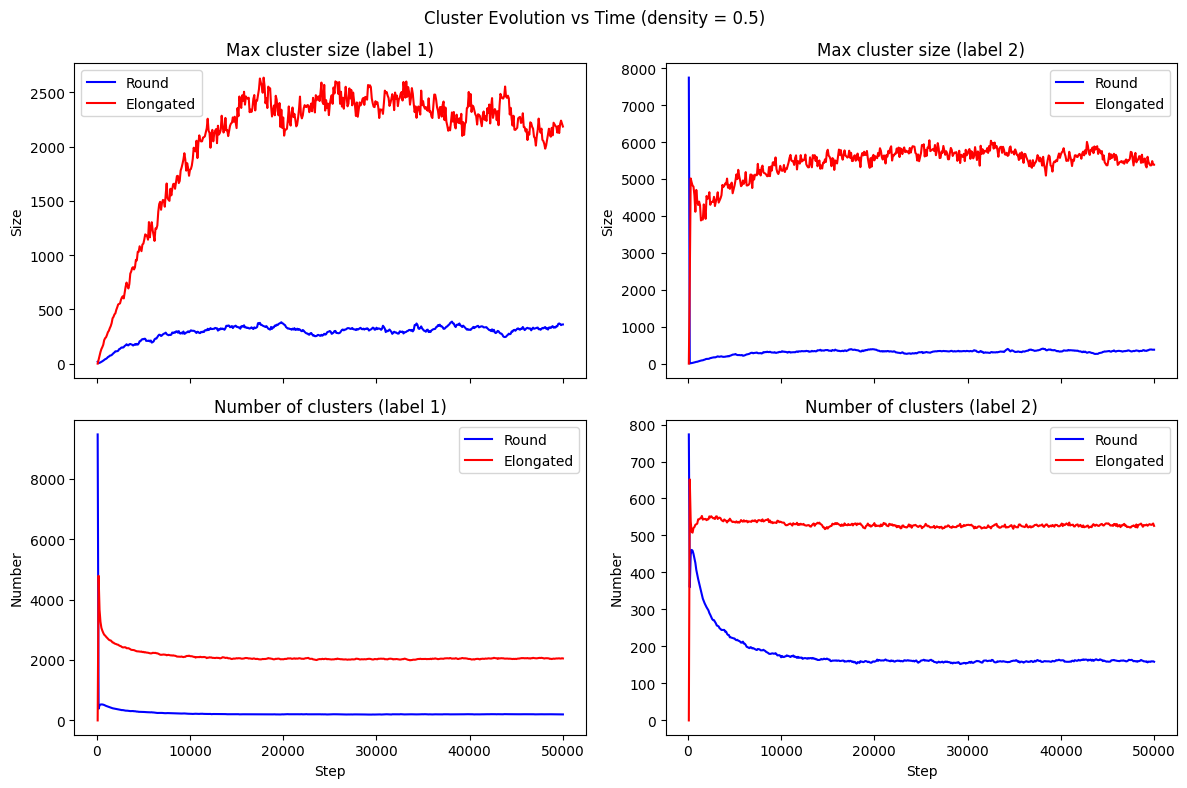

In [6]:
plot_cluster_evolution(df, dens=density)

### All densities

In the case we want to see all the densities, we can proceed like this: 

Last step =  50000  for density =  0.5


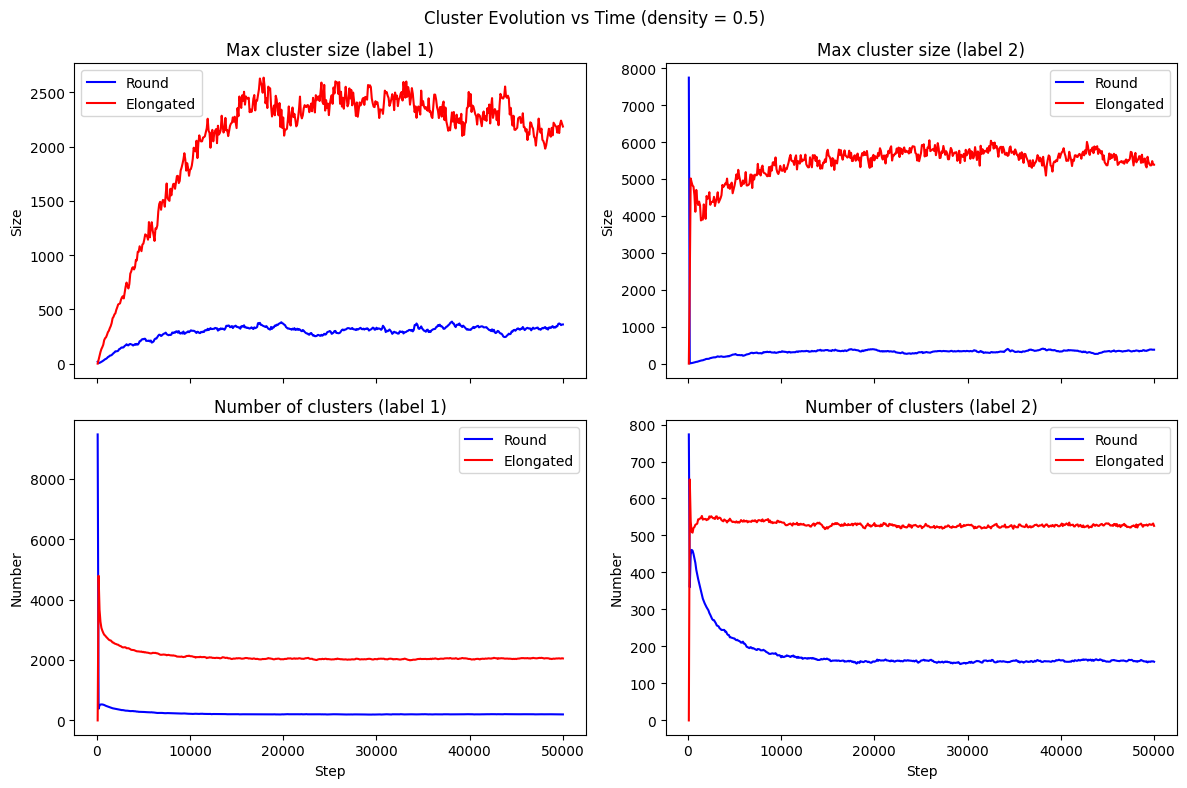

Last step =  50000  for density =  0.6


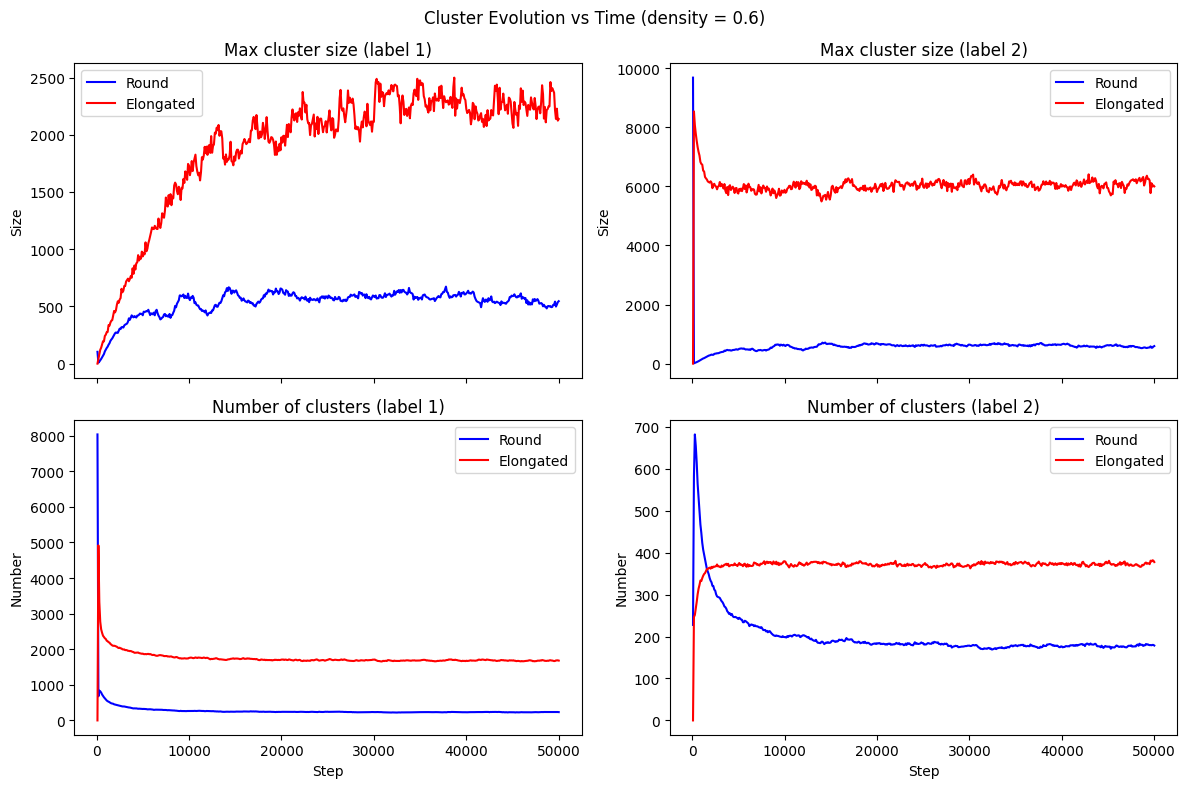

Last step =  50000  for density =  0.7


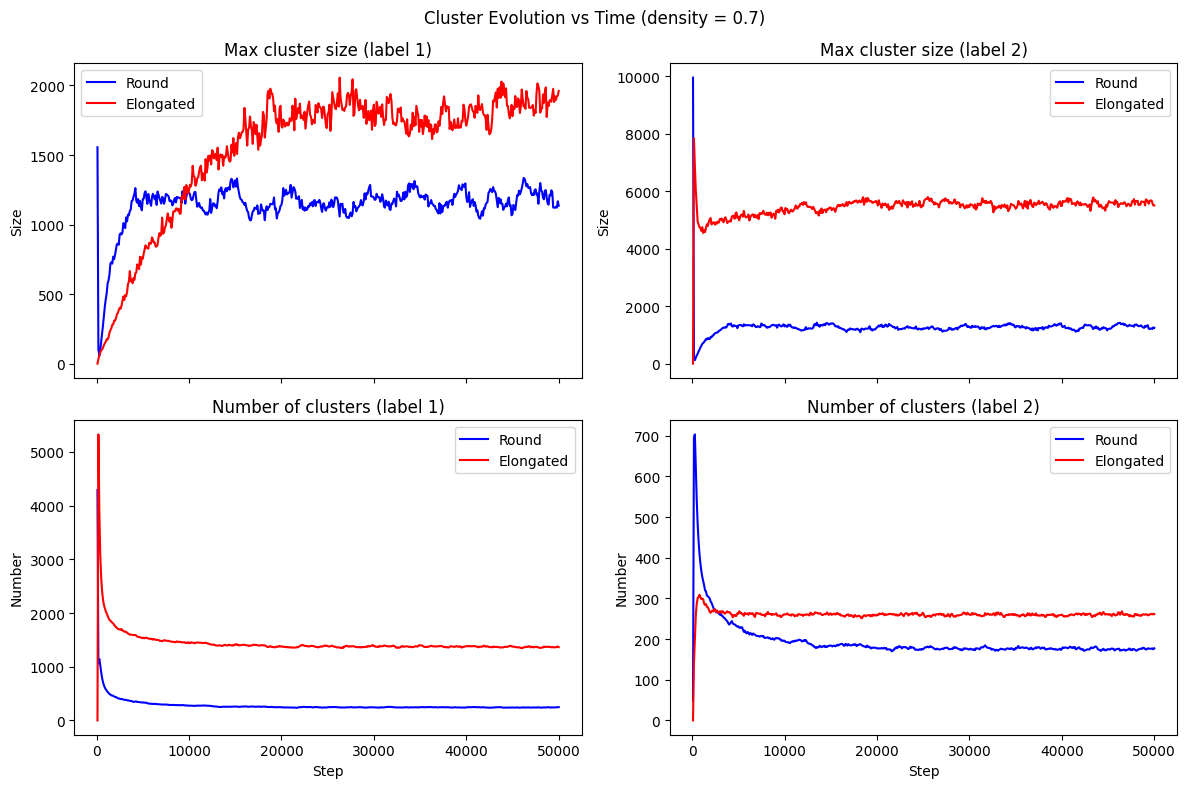

Last step =  50000  for density =  0.8


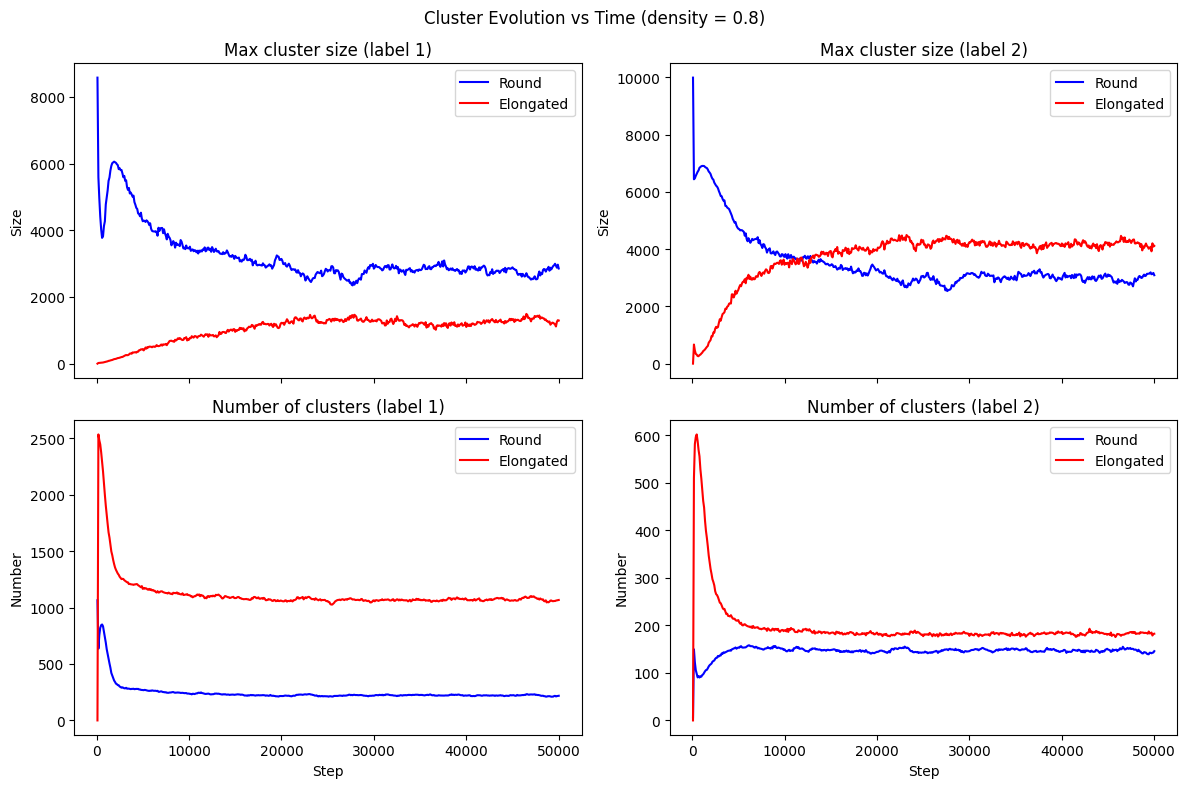

Last step =  48300  for density =  0.85


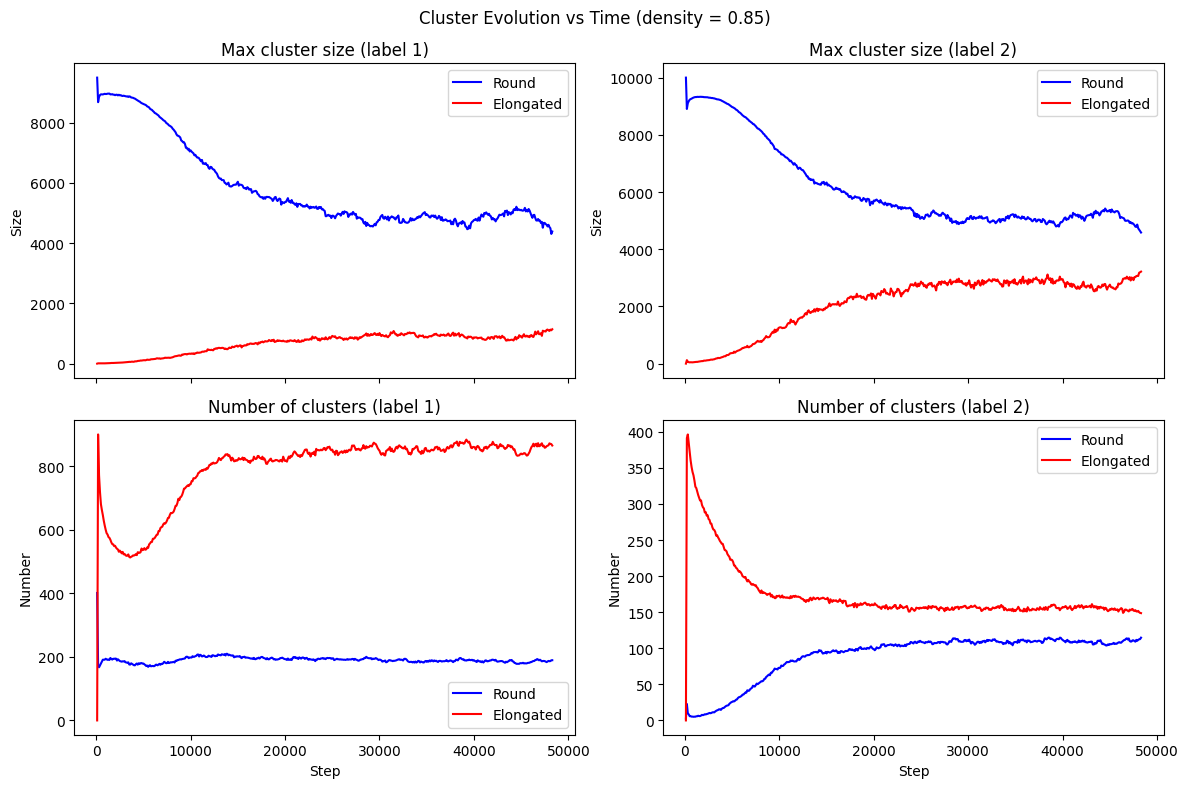

Last step =  10000  for density =  0.9


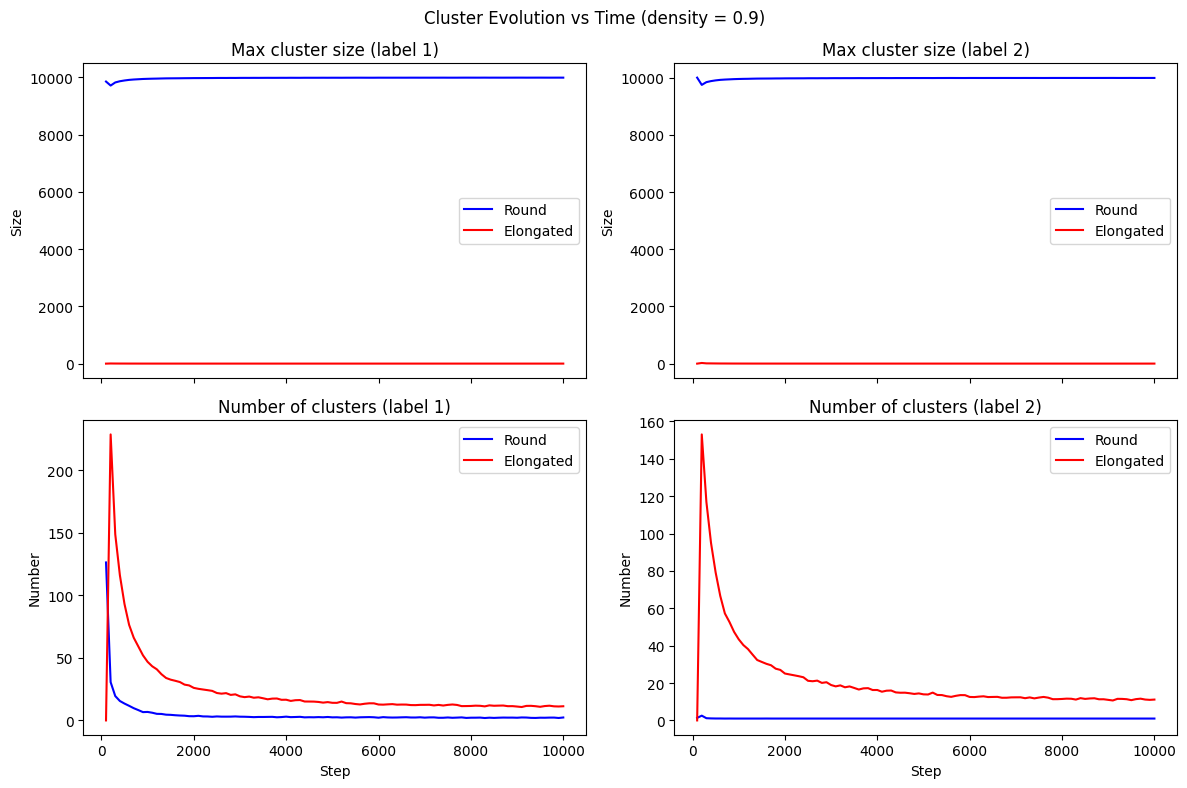

In [7]:
# Create a list with the densities
density_list = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
# Create a dict to save all the dataframes
dfs = {}

for density in density_list:
    # Call the function for the df in that density
    df = calculate_clusters_vs_time(num_cells=nc, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
    # df.to_csv(f"{density_folder}/clusters_vs_time_density_{density:.2f}.csv", index=False)
    # Add it to the dict
    dfs[density] = df # we can do, for example, dfs[0.85].head()
    # plot
    plot_cluster_evolution(df, dens=density)

# Final cluster distribution

Now we have a csv with all the sizes seen for every seed in the last step for a given density. Let's do a function to plot the distribution.

In [8]:
def log_hist(ax, data, color, label, alpha=0.7):
    """
    Adds a histogram with logarithmic bins to an existing axis.
    """
    data = np.array(data.dropna())
    if len(data) == 0:
        return

    bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 20)
    ax.hist(data, bins=bins, color=color, alpha=alpha, label=label)

def plot_cluster_size_distribution(density, num_cells):
    """
    Plots and saves histograms of cluster size distributions
    for both label and label2 (round and elongated).
    """
    dens_folder = f"{density:.2f}".replace(".", "_")
    input_file = f"{dens_folder}/cluster_distributions_final/cluster_size_distribution_cells={num_cells}_density={density:.2f}.csv"

    if not os.path.exists(input_file):
        print(f"File not found: {input_file}")
        return

    # Create the folder to save the figure
    output_dir = f"graphs/clusters/{dens_folder}"
    os.makedirs(output_dir, exist_ok=True)

    # Read the data
    df = pd.read_csv(input_file)

    # Create the figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # First plot, label 1
    log_hist(axes[0], df['sizes_round'], color='skyblue', label='Round', alpha=0.9)
    log_hist(axes[0], df['sizes_elongated'], color='tomato', label='Elongated', alpha=0.6)
    axes[0].set_title(f'Label 1 — density {density}')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Cluster size')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    # Second plot, label 2
    log_hist(axes[1], df['sizes_round_2'], color='skyblue', label='Round', alpha=0.9)
    log_hist(axes[1], df['sizes_elongated_2'], color='tomato', label='Elongated', alpha=0.6)
    axes[1].set_title(f'Label 2 — density {density}')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Cluster size')
    axes[1].legend()

    # Save
    plt.tight_layout()
    output_path = f"{output_dir}/cluster_size_distribution_density={density:.2f}.png"
    plt.savefig(output_path)
    plt.show()
    plt.close()

### Particular density

In the case we want to see only one particular density, continue as follows.

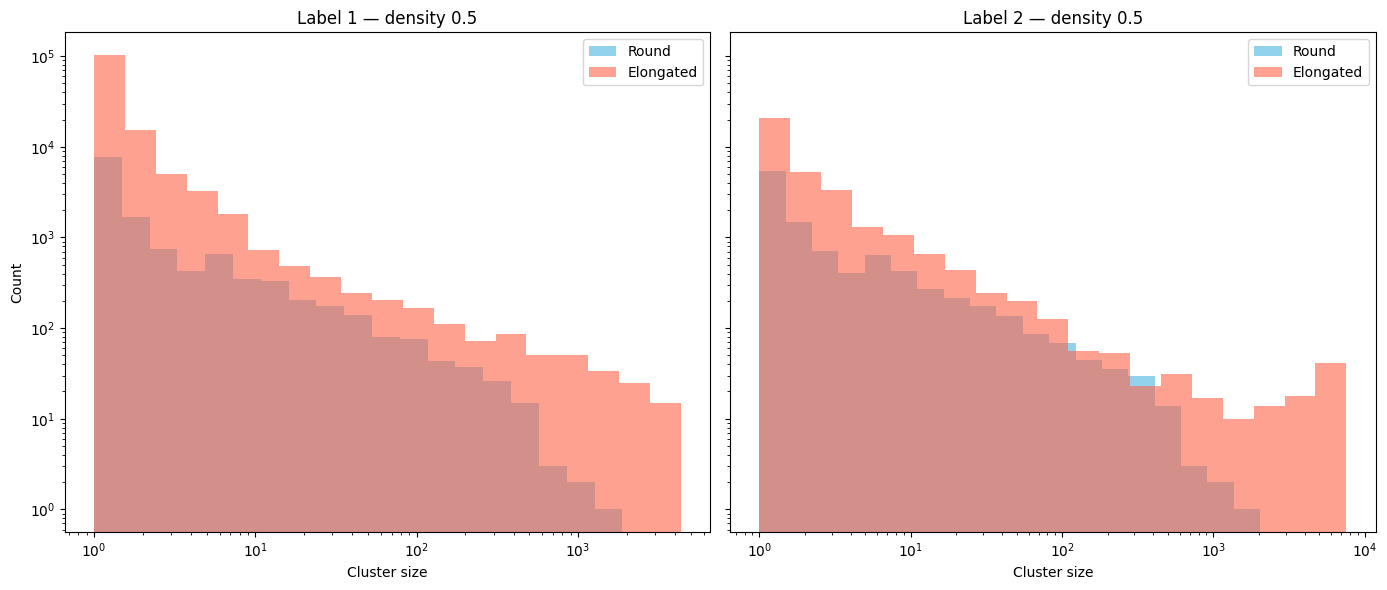

In [9]:
dens_input = input("Enter density (for example 0.90): ")
try:
    density = float(dens_input)
except ValueError:
    print("Error")
    exit()
plot_cluster_size_distribution(density=density, num_cells=nc)

### All densities

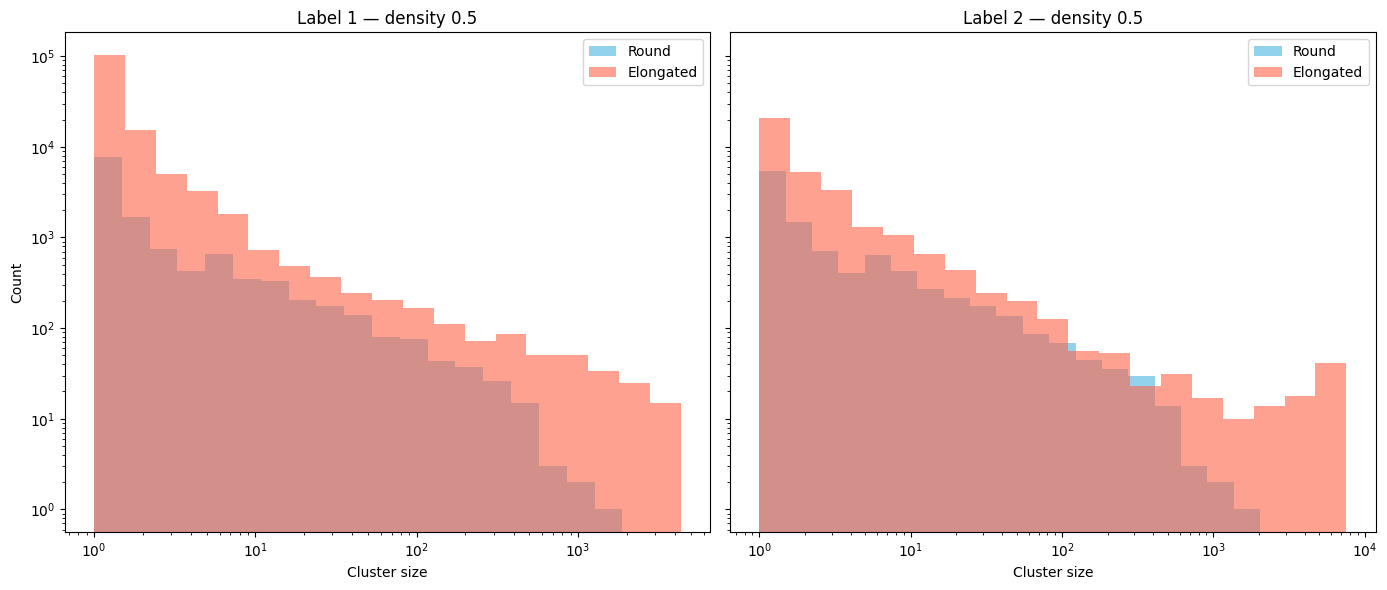

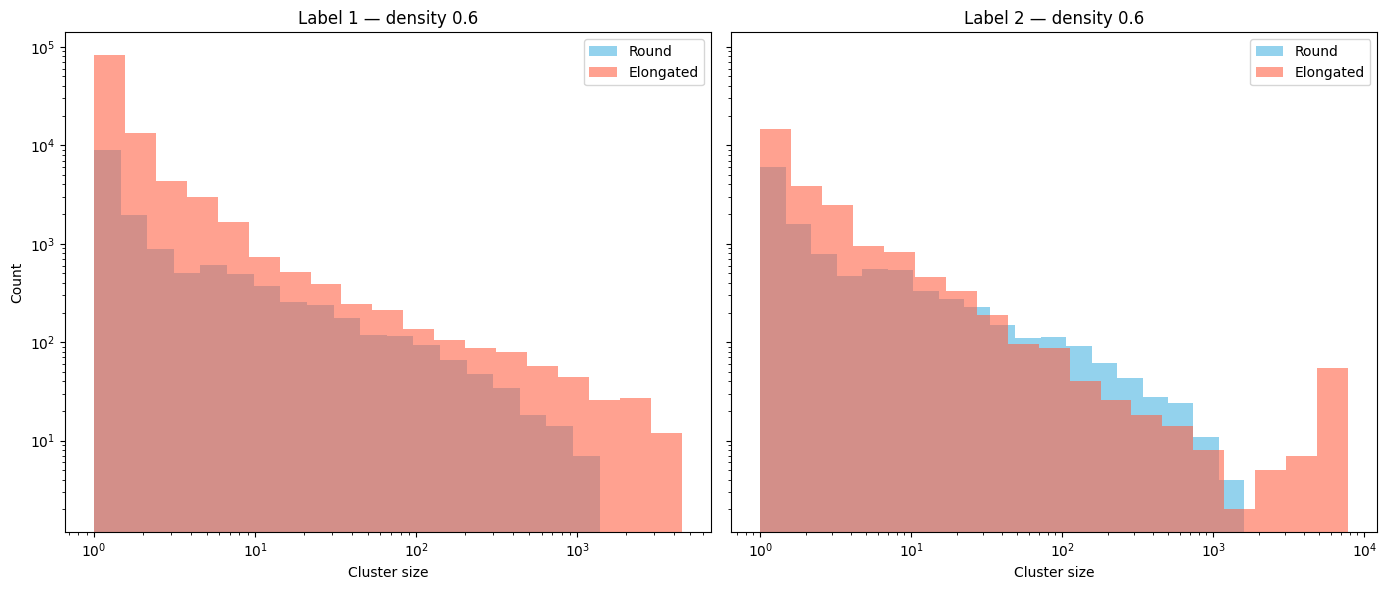

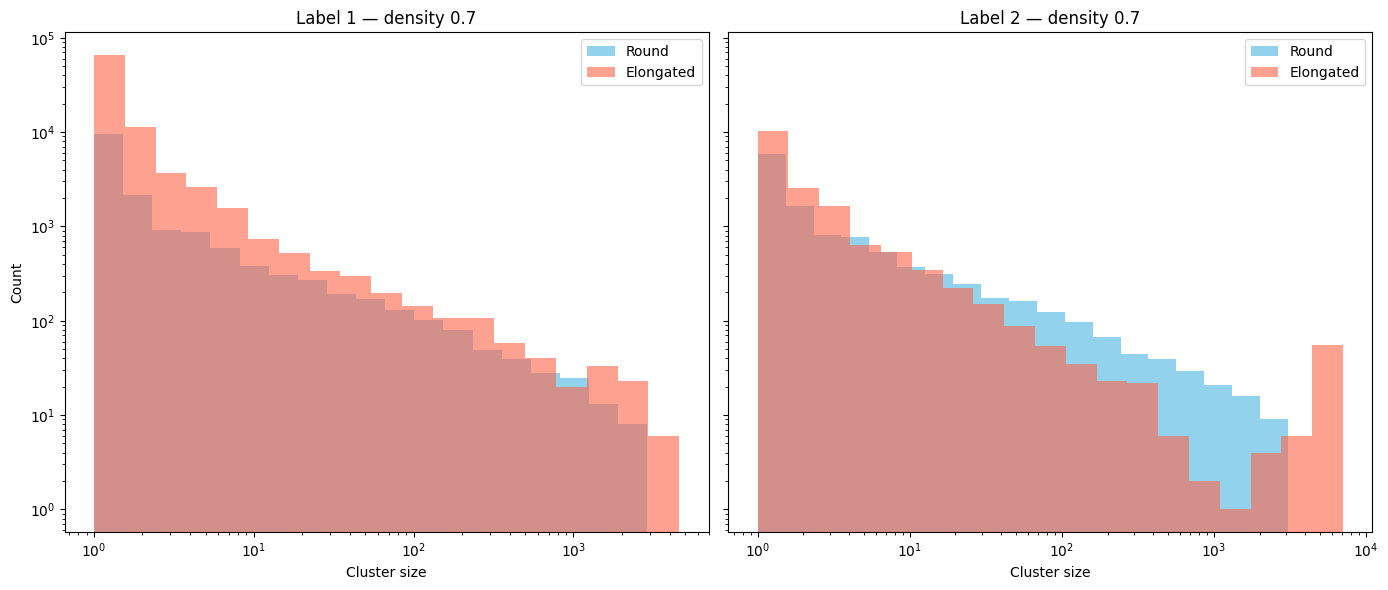

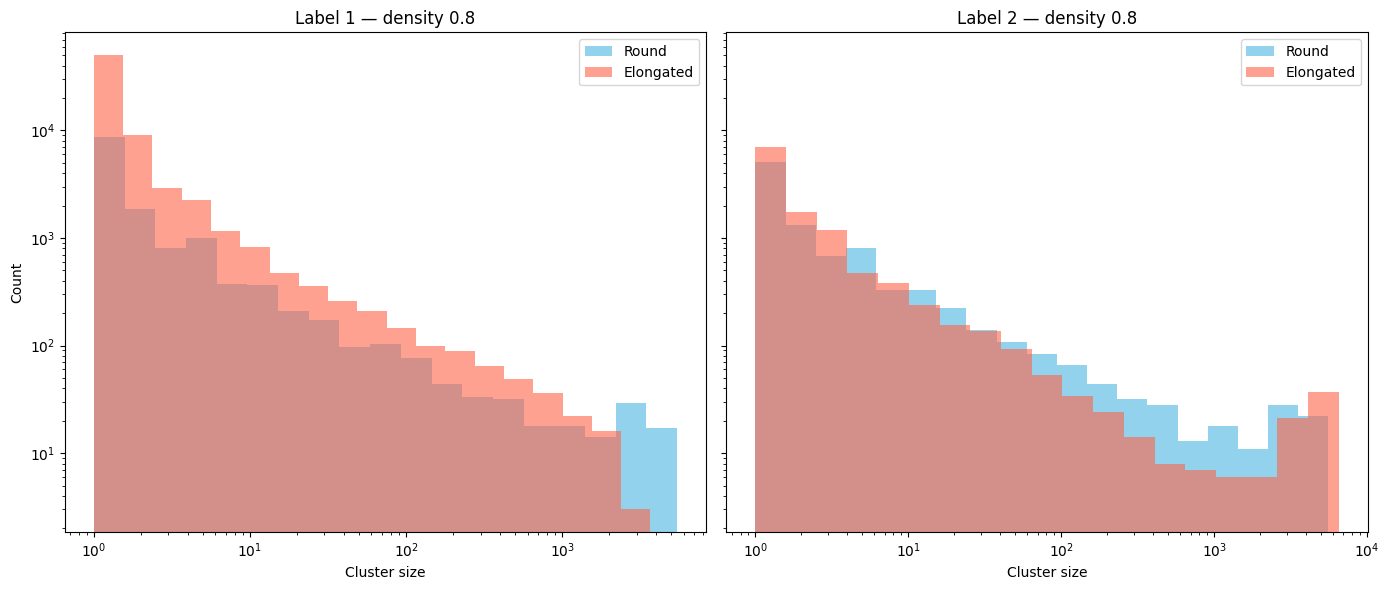

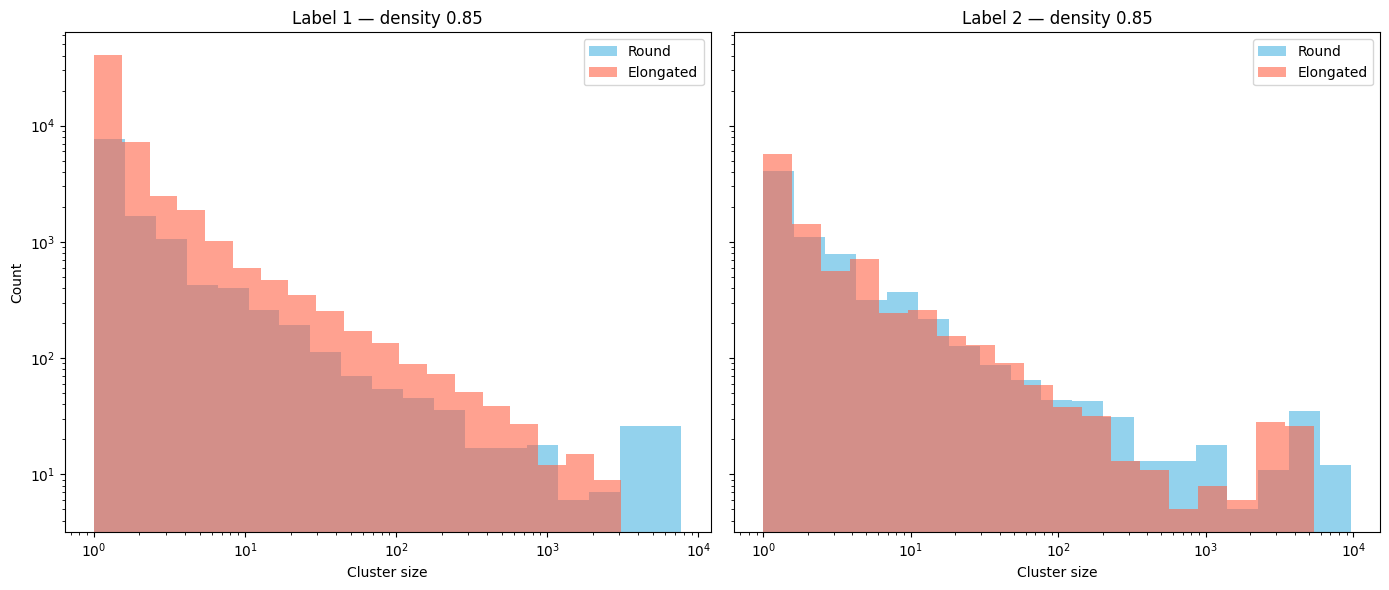

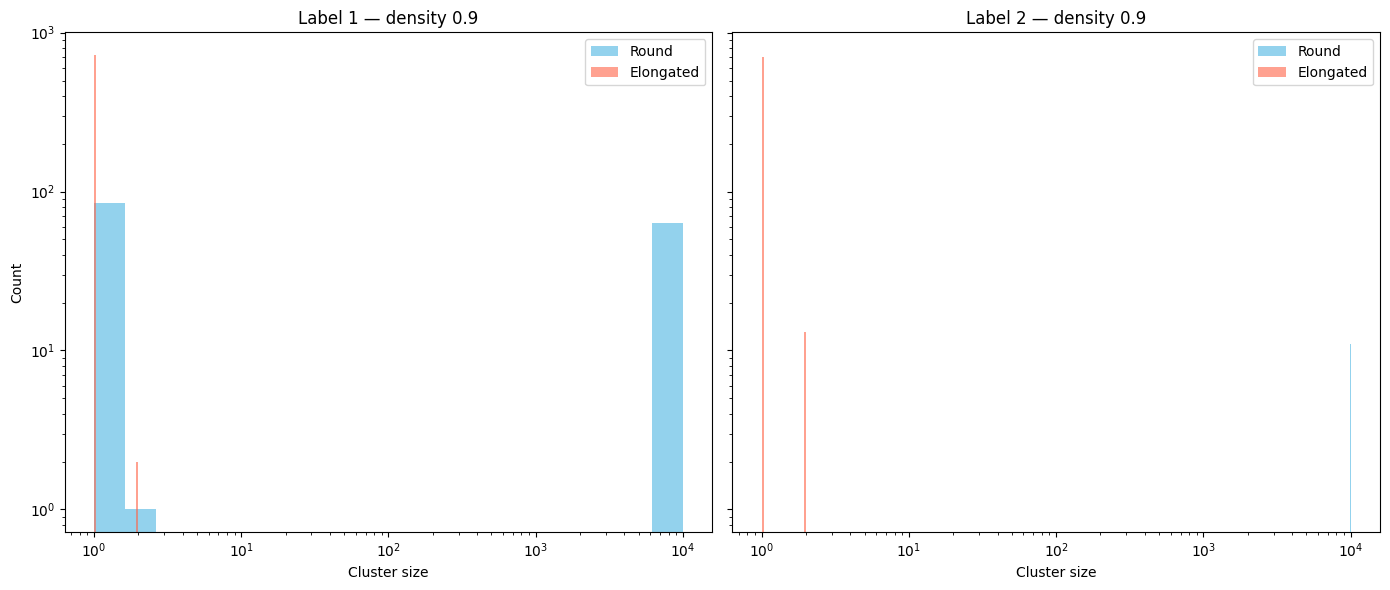

In [10]:
# Create a list with the densities
density_list = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]

for d in density_list:
    # plot
    plot_cluster_size_distribution(density=d, num_cells=nc)

Superponer.
Bineo logarítmico.
